In [1]:
%matplotlib inline
import os
import cv2
import seaborn 
import numpy as np
import pandas as pd 
import random
import tqdm
from tqdm import notebook
import albumentations as A
from albumentations import pytorch
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision
from torchviz import make_dot
import warnings
warnings.filterwarnings('ignore')

In [2]:
#data
data_dir = 'Brestcancer'
images_dir = os.path.join(data_dir, 'images')
masks_dir = os.path.join(data_dir, 'masks')
working_dir = 'Brestcancer/work'
weights_path = os.path.join(working_dir, 'segmentation_unet4_weights.pth')
logs_path = os.path.join(working_dir, 'logs')


In [3]:
#Custom Generator

class Generator(object):
    def __init__(self, images_dir, masks_dir, batch_size, is_augmentation, is_binary = False, shuffle = True, rescale = 1.00, target_size = (128, 128)):
        super(Generator, self).__init__()
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.is_binary = is_binary
        self.batch_size = batch_size
        self.rescale = rescale
        self.shuffle = shuffle
        self.is_augmentation = is_augmentation
        self.target_size = target_size
        self.image_filenames = [os.path.join(self.images_dir, filename) for filename in os.listdir(self.images_dir)]
        self.mask_filenames = [os.path.join(self.masks_dir, filename) for filename in os.listdir(self.masks_dir)]
        self.current_step = 0
        self.count_images = len(self.image_filenames)
        self.available_steps = int(self.count_images // self.batch_size)
        
        self.transforms = A.Compose([
            A.Rotate(65), 
            A.OneOf([
                A.RGBShift(), A.HueSaturationValue()
            ]),
            A.OneOf([
                A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()
            ]), 
        ])
    
    def augmentate(self, batch):
        batch = batch.astype(np.uint8)
        batch = [self.transforms(image = image, mask = mask) for (image, mask) in batch]
        batch = np.array([(transformed['image'], transformed['mask']) for transformed in batch], dtype = np.float32)
        return batch
            
    def generate_batch(self):
        start = self.current_step * self.batch_size
        stop = (self.current_step + 1) * self.batch_size
        image_filenames_batch = self.image_filenames[start:stop]
        mask_filenames_batch = self.mask_filenames[start:stop]
        
        # batch of original images from directory
        images_batch = [cv2.imread(filename) for filename in image_filenames_batch]
        masks_batch = [cv2.imread(filename) for filename in mask_filenames_batch]
        
        # change channels order to rgb
        images_batch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_batch])
        masks_batch = np.array([cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) for mask in masks_batch])
        
        # resize images 
        images_batch = np.array([(cv2.resize(images_batch[index], self.target_size), cv2.resize(masks_batch[index], self.target_size)) for index in range(len(images_batch))])
        
        # augmentation
        if self.is_augmentation:
            images_batch = self.augmentate(images_batch)
        
         # set 'channel_first' order
        images_batch = np.array([(np.moveaxis(image, -1, 0), np.moveaxis(mask, -1, 0)) for (image, mask) in images_batch])
        
        # rescaling 
        images_batch /= self.rescale
        
        #resampling 
        images, masks = np.moveaxis(images_batch, 1, 0)
        images, masks = np.array(images), np.array(masks)
        
        # set binary format for image if required
        if self.is_binary:
            masks = np.array([np.expand_dims(mask[0], axis = 0) for mask in masks])
        
        images, masks = torch.Tensor(images), torch.Tensor(masks)
        
        return images, masks
    
    def __next__(self):
        if self.current_step > self.available_steps:
            self.current_step = 0
        images, masks = self.generate_batch()
        self.current_step += 1
        return images, masks
    
    def __len__(self):
        return self.available_steps


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


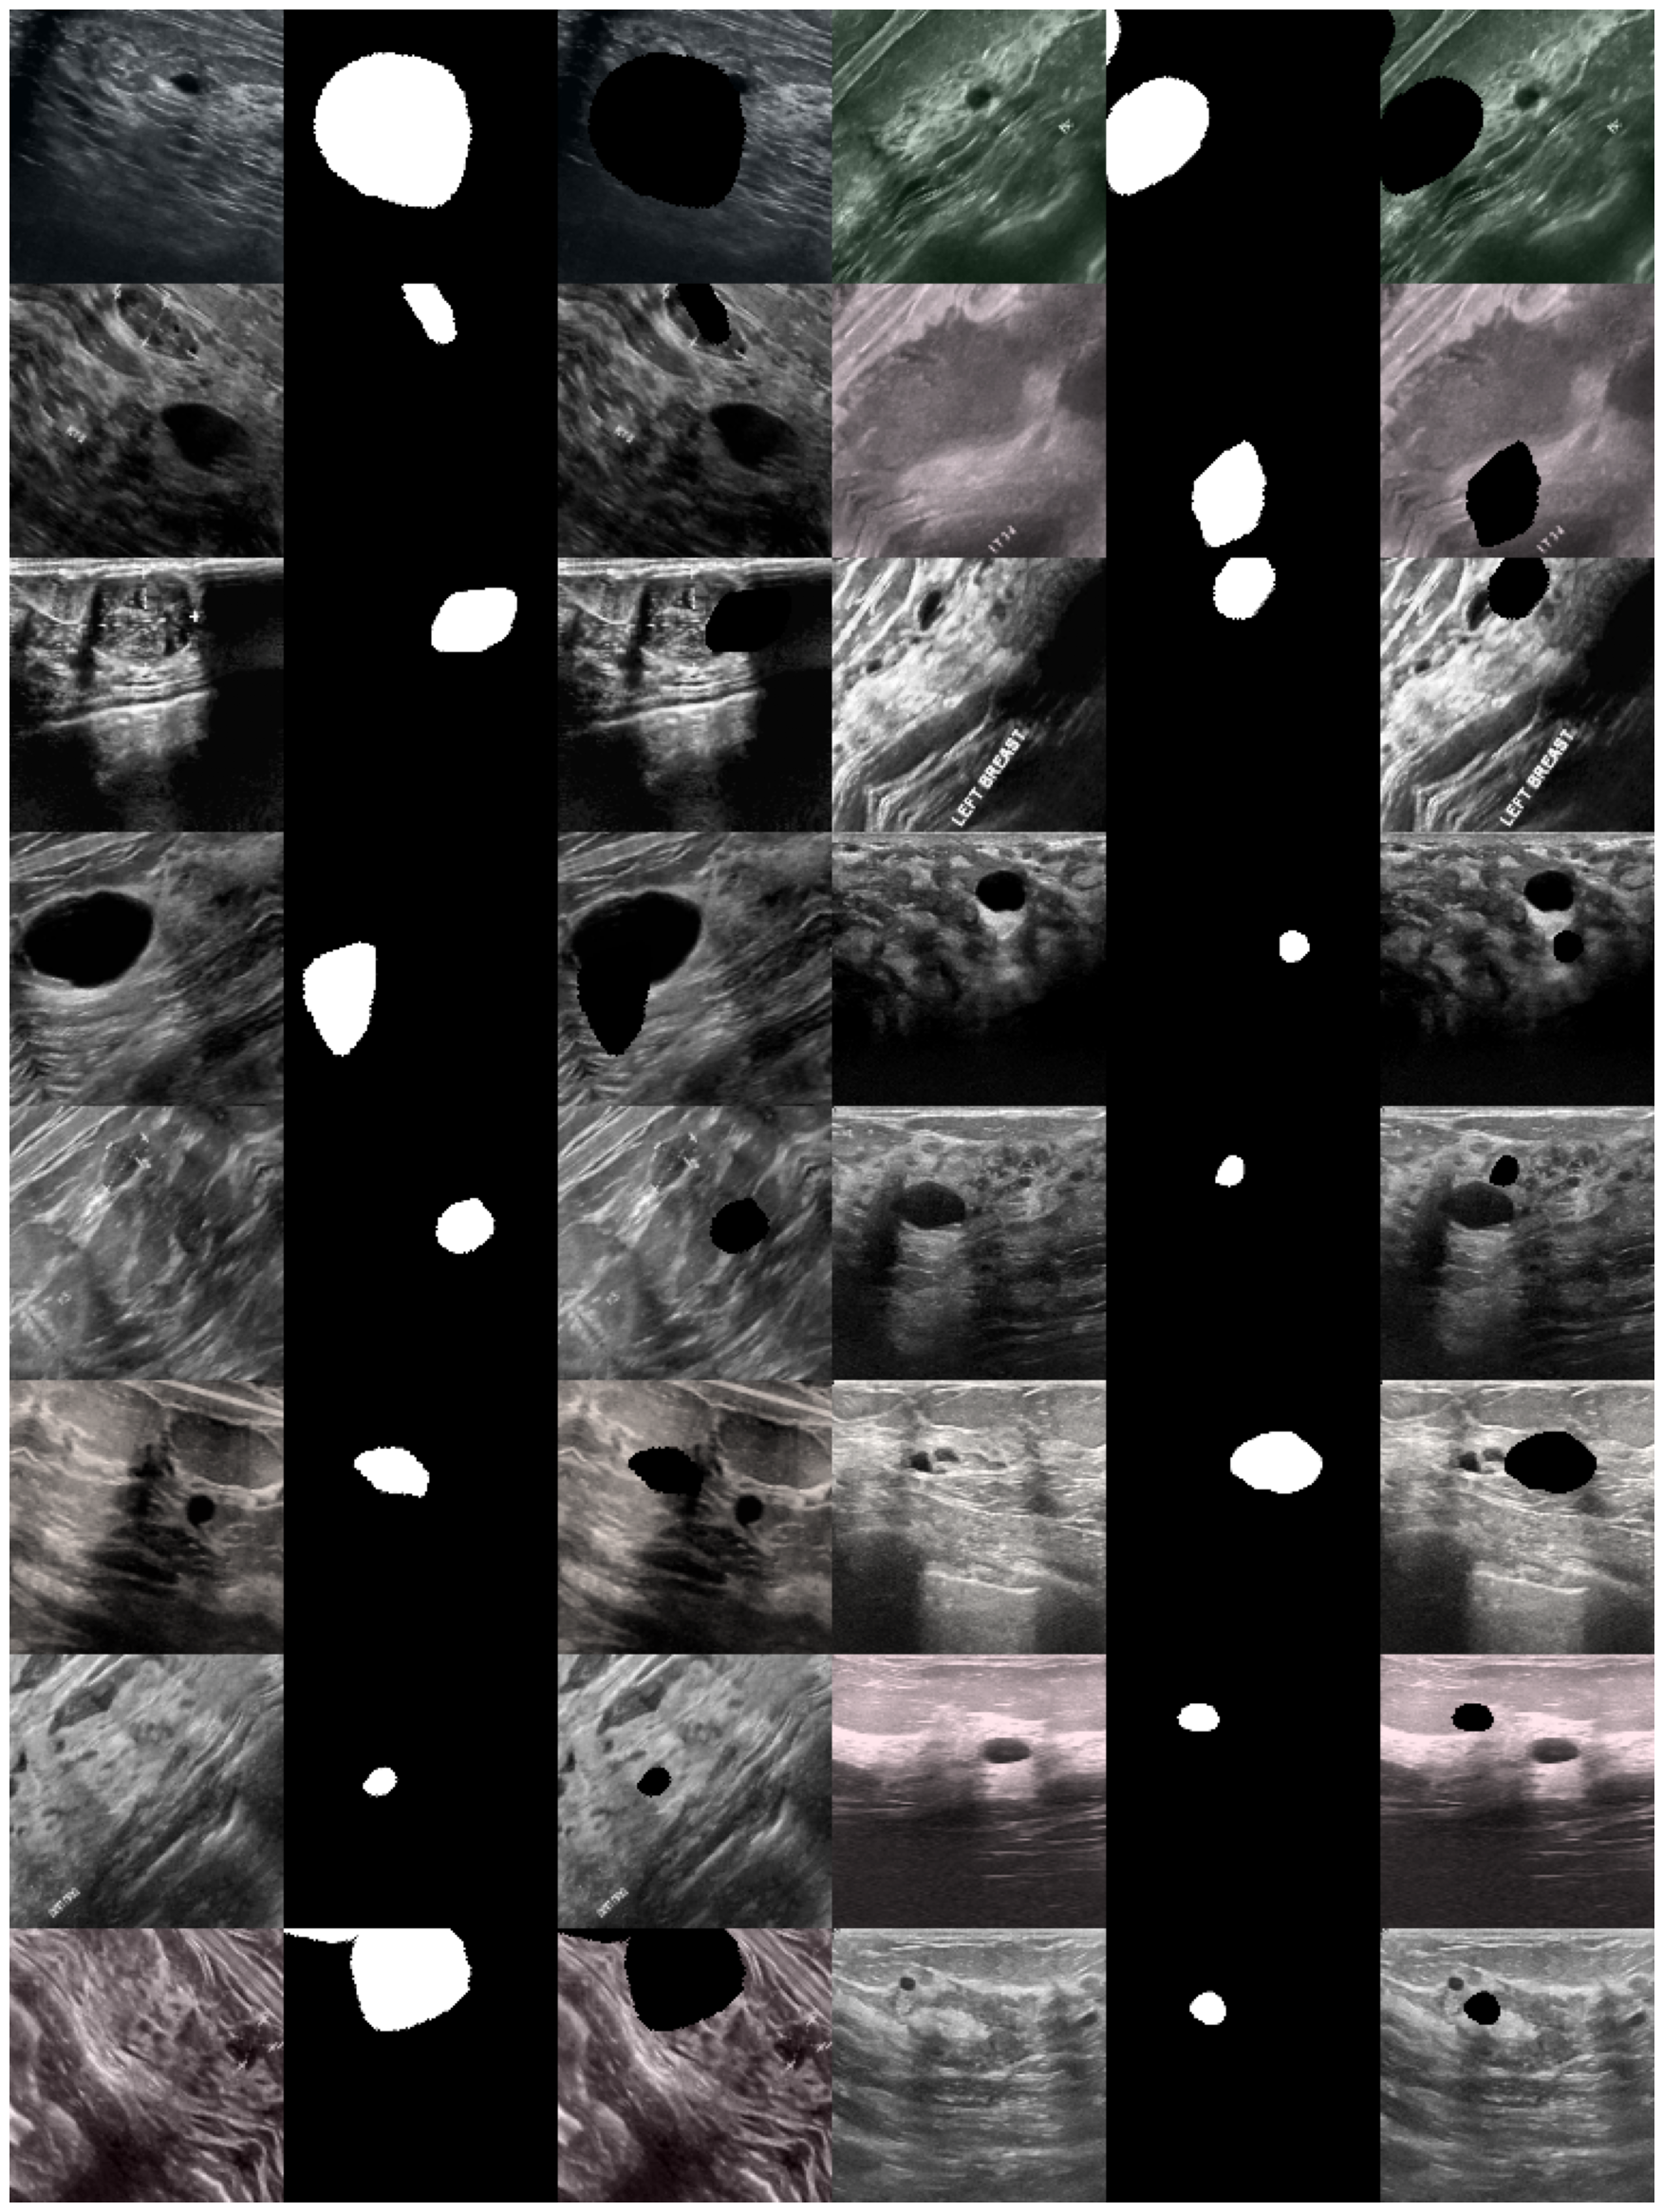

In [4]:
#display
def show_examples(num_cols):
    stacks = []
    dataloader = Generator(images_dir = images_dir, masks_dir = masks_dir, is_binary = False, batch_size = 8, is_augmentation = True, rescale = 255.0)
    for iteration in range(num_cols):
        images, masks = next(dataloader)
        images, masks = images.numpy(), masks.numpy()
        images, masks = np.concatenate(np.moveaxis(images, 1, -1)), np.concatenate(np.moveaxis(masks, 1, -1))
        embedded = images - masks
        stack = np.hstack([images, masks, embedded])
        stacks.append(stack)
    result = np.hstack(stacks)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)
    
show_examples(2)

In [5]:
#model

class DoubleConv(nn.Module):
    """convolution =>BN=> (ReLU)*2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 2**5)
        self.down1 = Down(2**5, 2**6)
        self.down2 = Down(2**6, 2**7)
        self.down3 = Down(2**7, 2**8)
        factor = 2 if bilinear else 1
        self.down4 = Down(2**8, 2**9 // factor)
        self.up1 = Up(2**9, 2**8 // factor, bilinear)
        self.up2 = Up(2**8, 2**7 // factor, bilinear)
        self.up3 = Up(2**7, 2**6 // factor, bilinear)
        self.up4 = Up(2**6, 2**5, bilinear)
        self.outc = OutConv(2**5, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits    



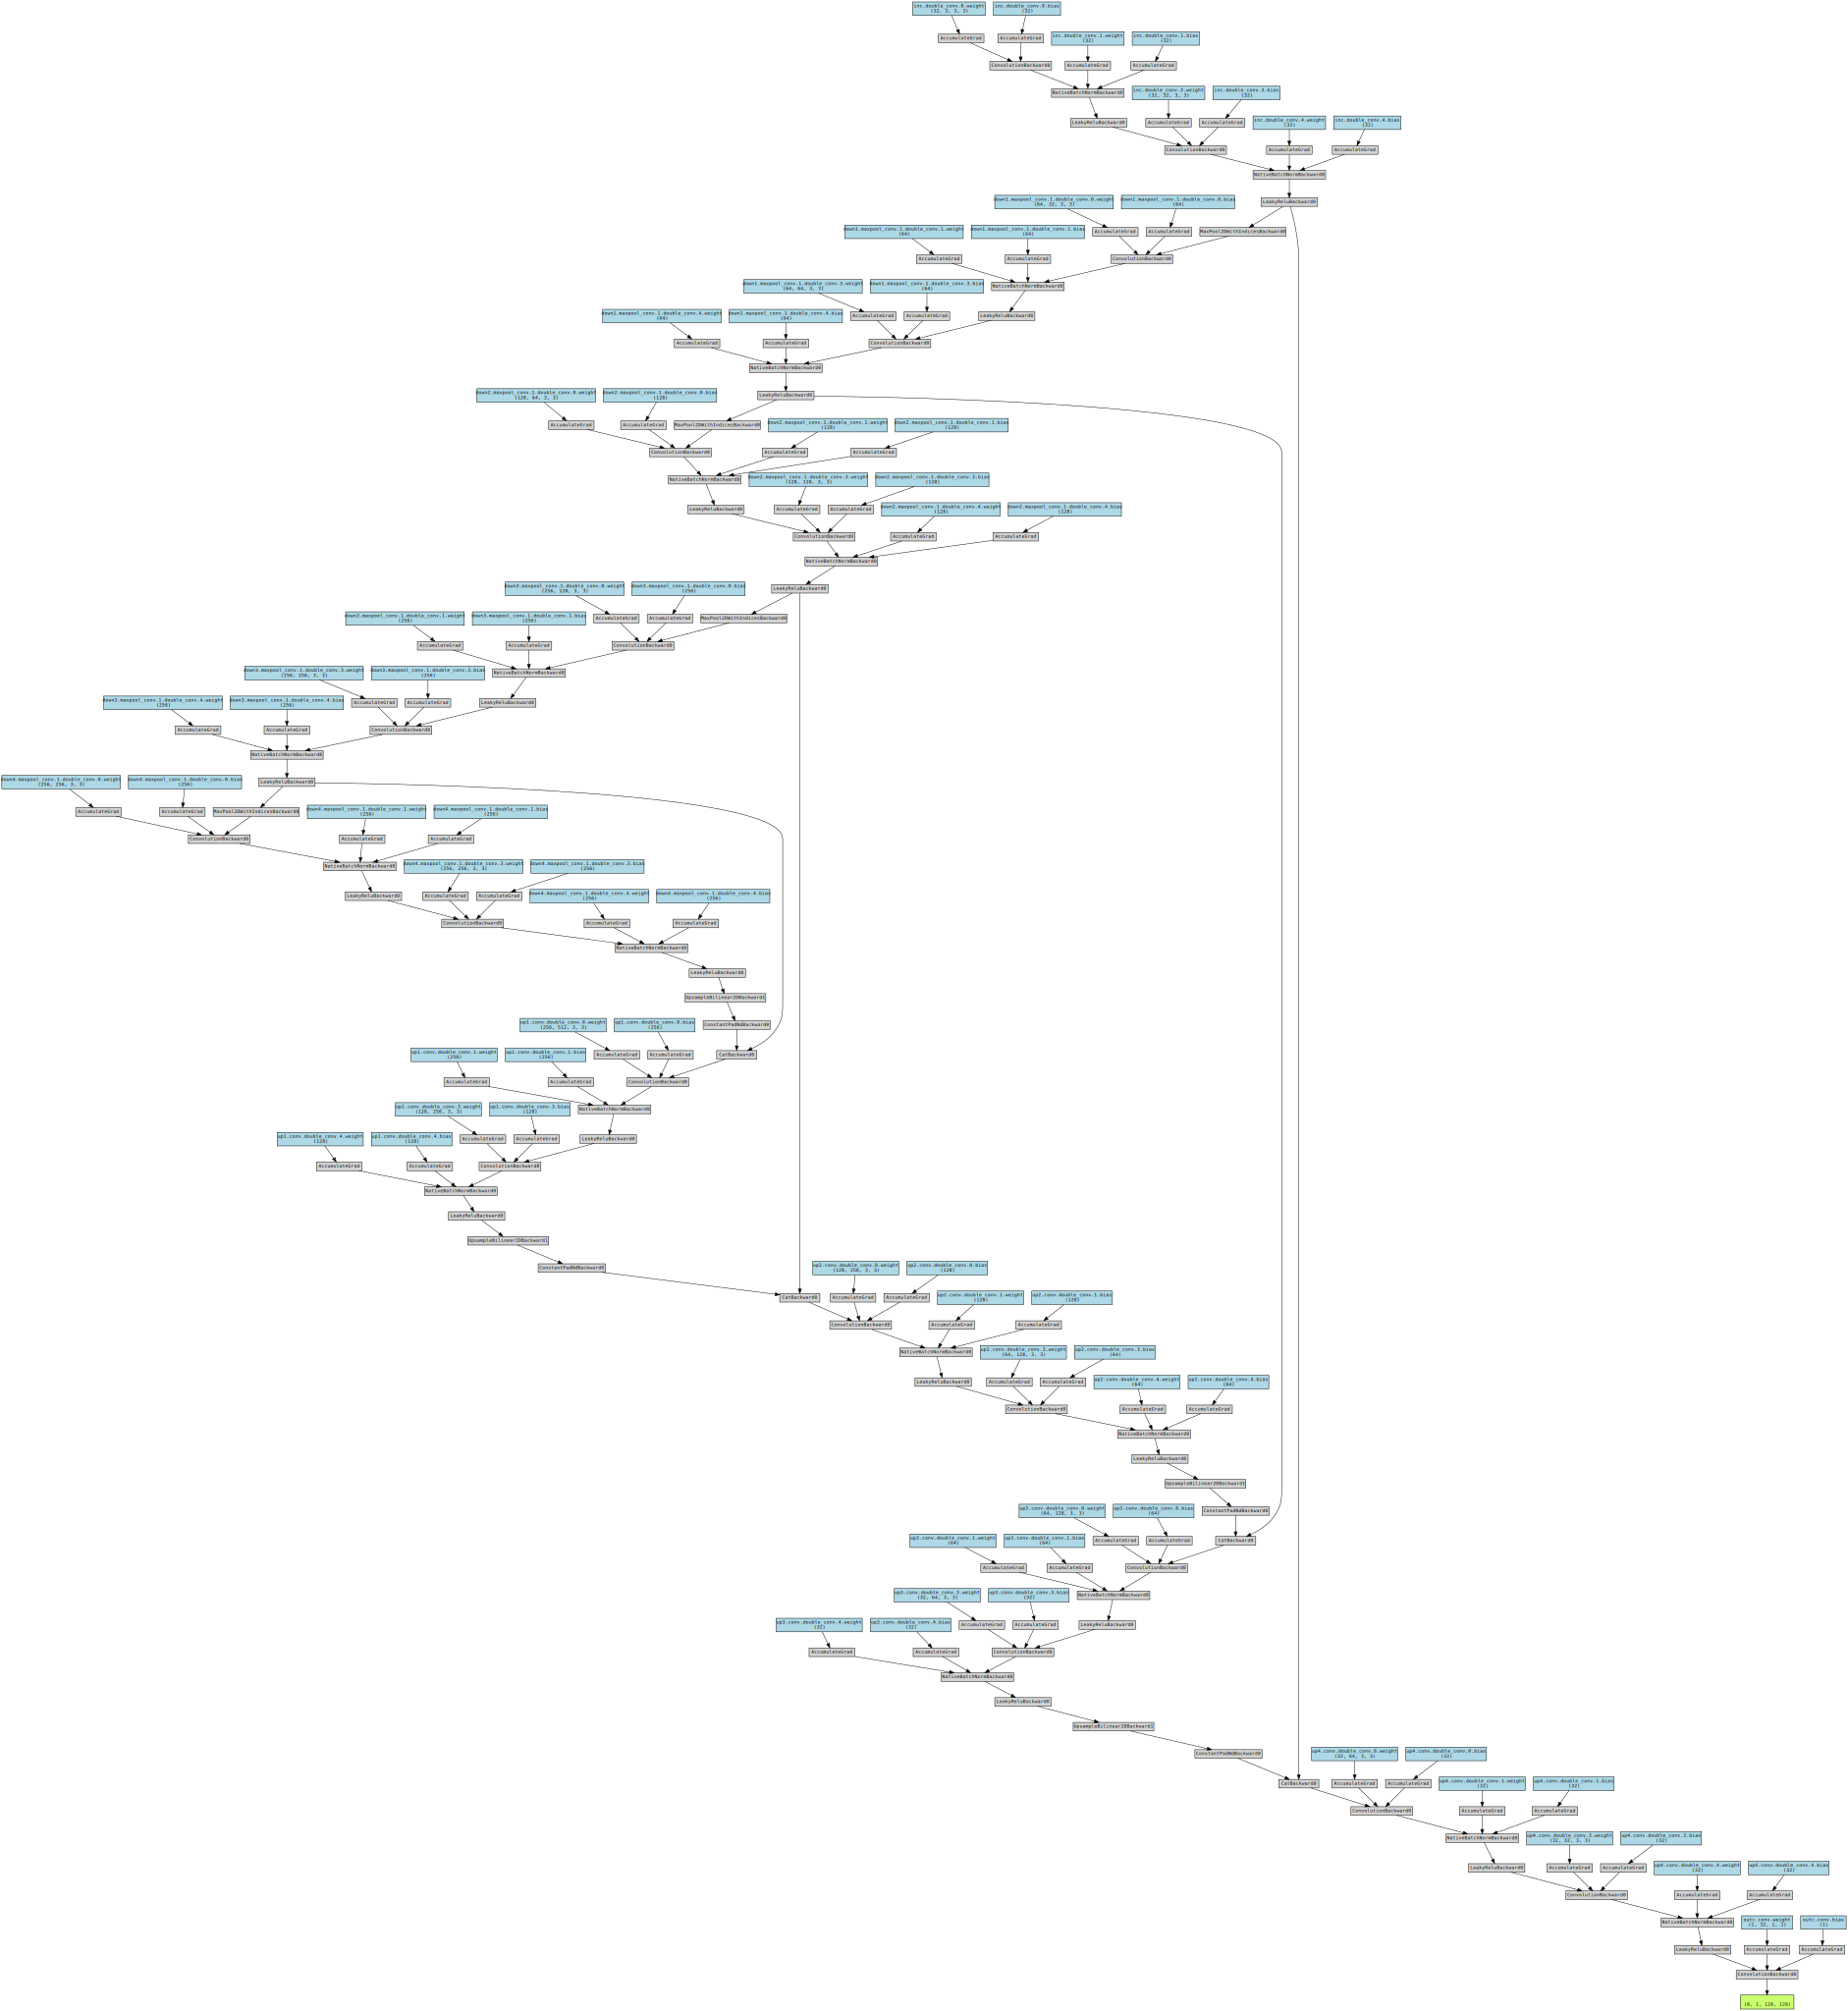

In [6]:
#complie
unet = UNet(n_channels=3, n_classes=1, bilinear=True)
x = torch.zeros(8, 3, 128, 128, dtype=torch.float, requires_grad=False)
out = unet(x)
make_dot(out, params=dict(list(unet.named_parameters())))

In [7]:
#Training
optimizer = torch.optim.Adam(params = unet.parameters(), 
                             lr=1e-4, 
                             betas=(0.9, 0.999), 
                             eps=1e-08, 
                             weight_decay=0, 
                             amsgrad=False)

criterion = torch.nn.BCEWithLogitsLoss()

history = dict(train_loss = [], 
               train_dice_coeff = [], 
              )

def dice_coeff(pred, target):
    pred = (pred > 0).float()
    return 2. * (pred*target).sum() / (pred+target).sum()
            
def training(model, epochs, batch_size):
    
    train_generator = Generator(images_dir = images_dir, masks_dir = masks_dir, is_binary = True, batch_size = batch_size, is_augmentation = True, rescale = 255.0)    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    main_pbar = tqdm.notebook.tqdm(range(epochs))
    main_pbar.set_description('common progress ')
    
    for epoch in main_pbar:
        running_params = dict(train_loss = [], 
                               train_dice_coeff = [], 
                             )
        train_pbar = tqdm.notebook.tqdm(range(len(train_generator)))
        
        for step in train_pbar:            
            # obtain batches of data 
            train_images, train_masks = next(train_generator)
            train_images, train_masks = train_images.to(device), train_masks.to(device)
            
            # zero optimizer gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            train_predictions = model(train_images)
            # estimate loss and backward
            train_loss = criterion(train_predictions, train_masks)
            train_loss.backward()
            
            # estimate dice coeff
            train_dice_coeff = dice_coeff(pred = train_predictions, target = train_masks)
            
            # optimize
            optimizer.step()             
        
            
            # set current values in dictionary to store
            current_metrics = dict(train_loss = [train_loss.item(), ], 
                                   train_dice_coeff = [train_dice_coeff.item(), ], 
                                  )
            
            # update dictionary with current epochs
            running_params.update(current_metrics)
            # estimate mean values for each metrics
            mean_metrics = dict(zip(running_params.keys(), [(sum(tensor) / (step + 1)) for tensor in running_params.values()]))
            # update progress bar
            train_pbar.set_postfix(mean_metrics)
            # clear gpu memory
            torch.cuda.empty_cache()
        
        history.update(running_params)
        best_loss = max(history['train_loss'])
        best_loss_index = history['train_loss'].index(best_loss)
        current_loss_index = history['train_loss'].index(train_loss.item())
        if abs(current_loss_index - best_loss_index) >= 5:
            for param_group in optim.param_groups:
                if param_group['lr'] * 0.1 > 1e-6:
                    print('reduce learning rate to', {param_group['lr'] * 0.1})
                    param_group['lr'] *= 0.1

#parameters for model                  
nepochs = 20    
nbatchsize = 32
training(model = unet, epochs = nepochs, batch_size = nbatchsize)
torch.save(unet.state_dict(), weights_path)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [8]:
#model load
model = UNet(n_channels=3, n_classes=1, bilinear=True)
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [9]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'parameters : {params}')

parameters : 4320609


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


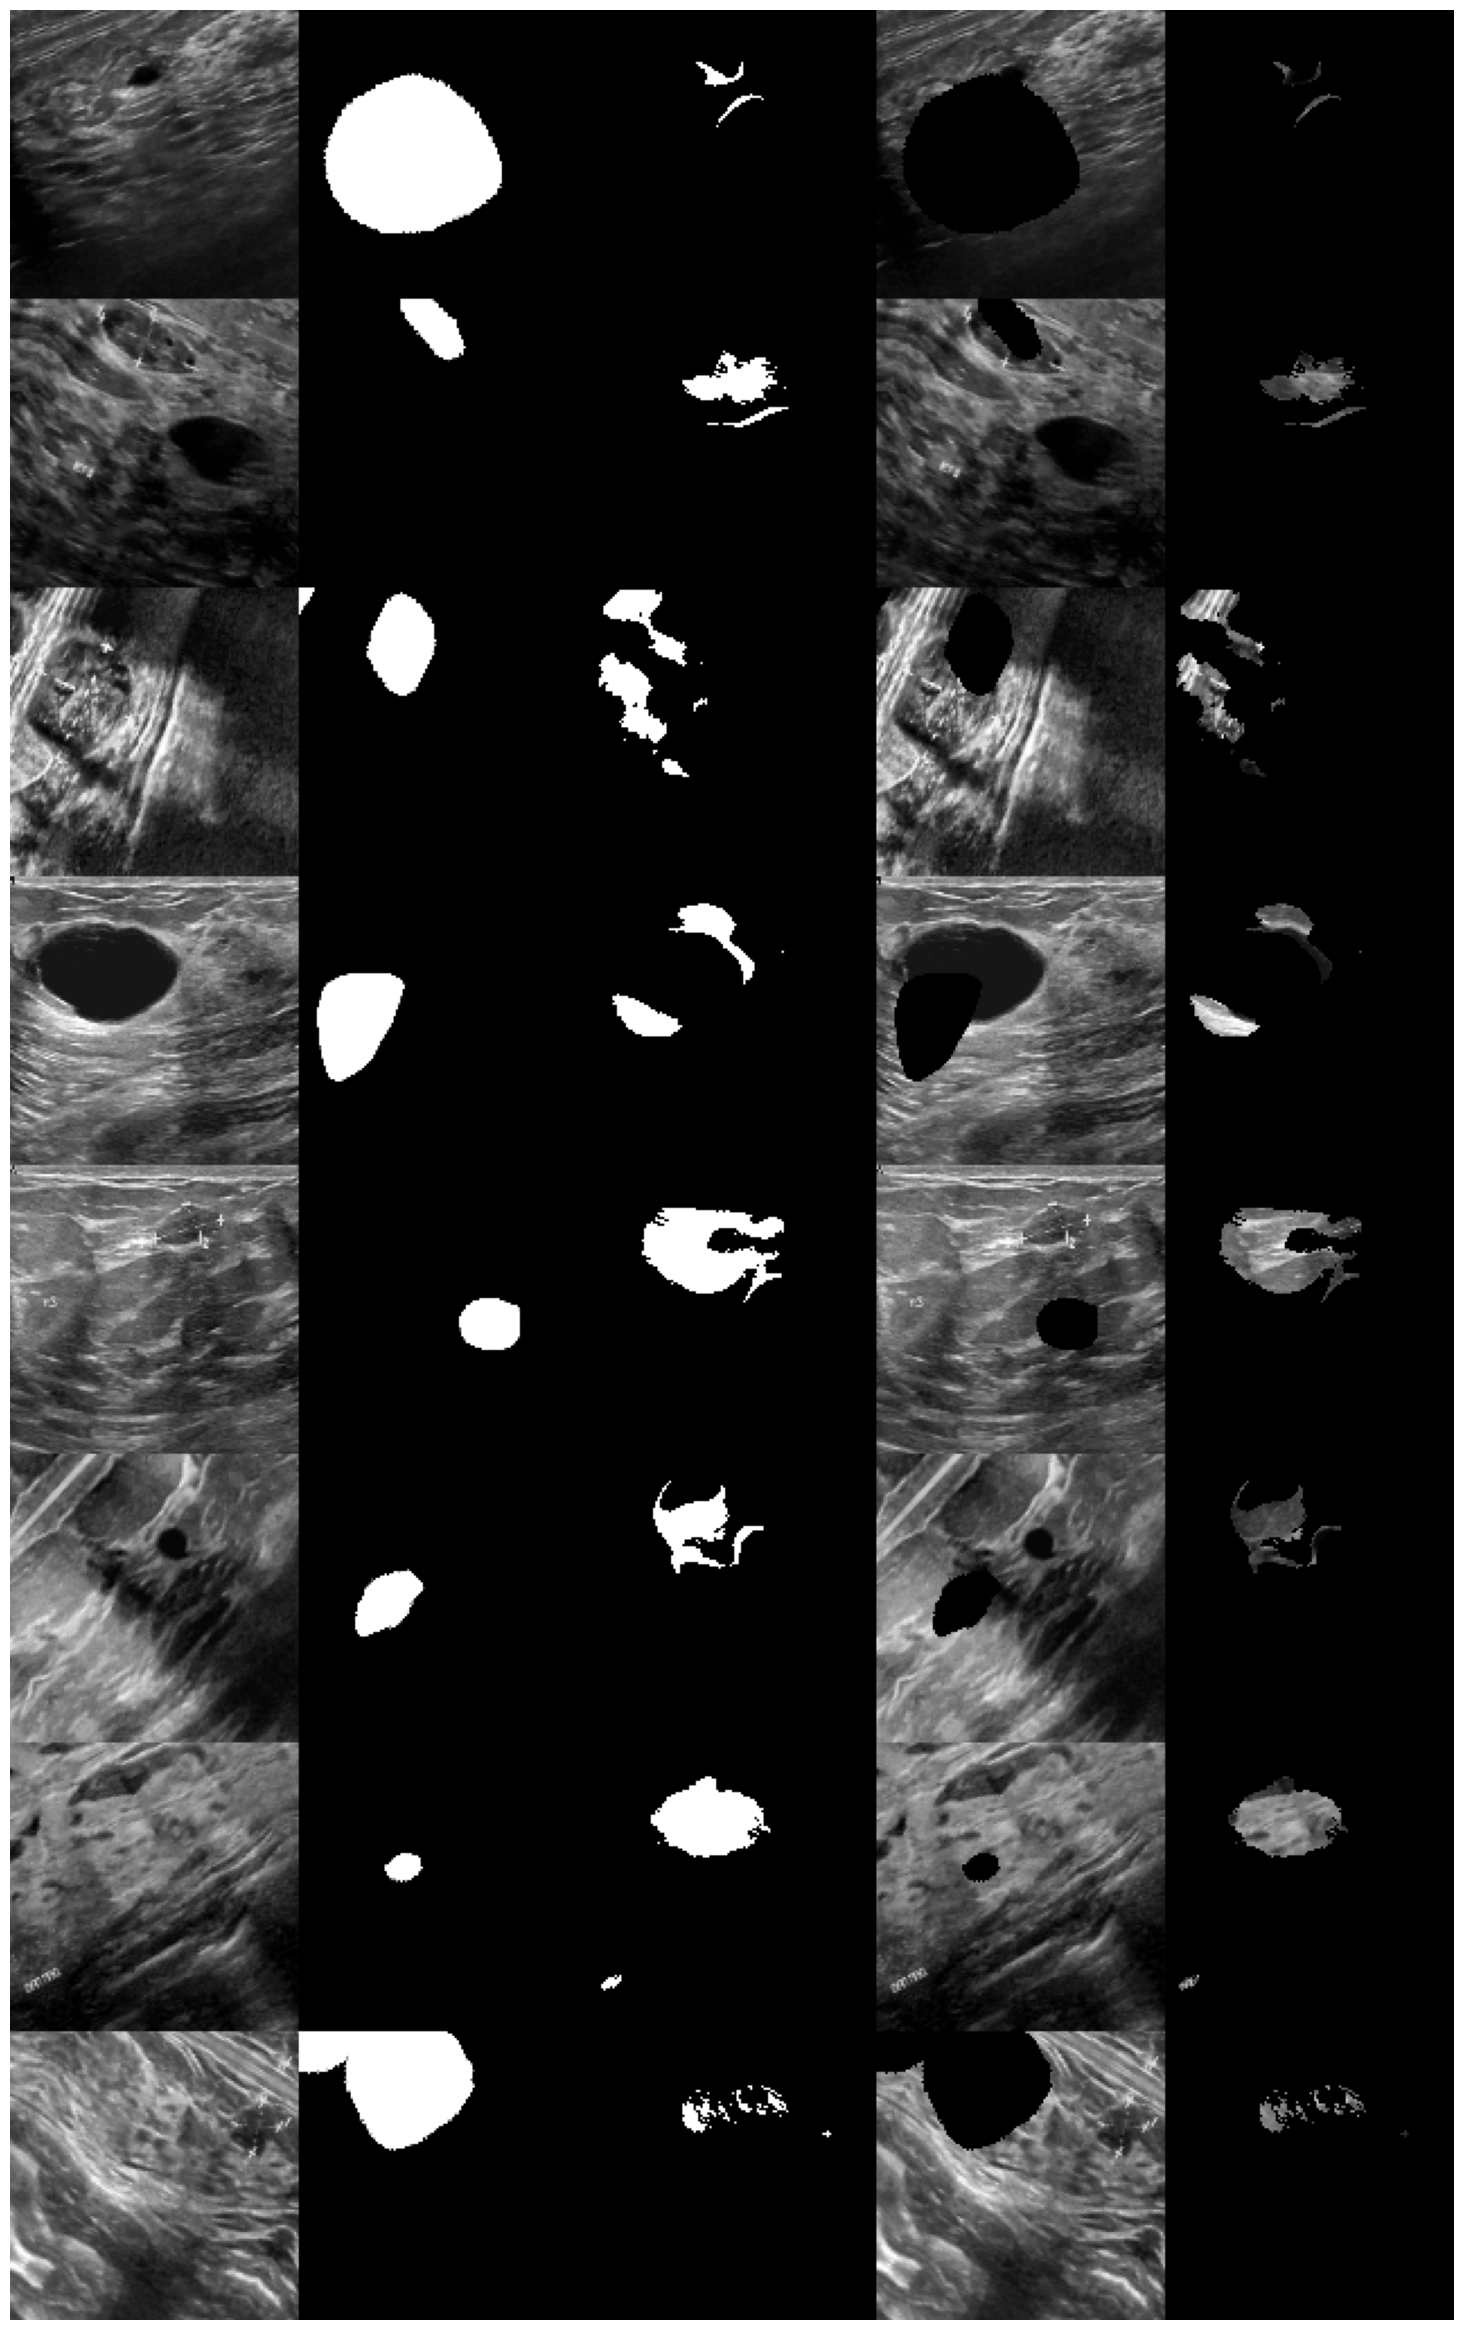

In [10]:
#Result

def show_final_results(num_cols, model, is_binary = True):
    generator = Generator(images_dir = images_dir, 
                          masks_dir = masks_dir, 
                          is_binary = True,
                           batch_size = 8, 
                           is_augmentation = True, 
                           rescale = 255.0)
    result = []
    
    
    for iteration in range(num_cols):
        images, masks = next(generator)
        prediction = model(images)
        prediction = prediction.cpu().detach().numpy()
        prediction = np.moveaxis(prediction, 1, -1)
        prediction[prediction < 0] = 0.0
        prediction[prediction > 0] = 1.0
        
        # processing
        images, masks = images.cpu().detach(), masks.cpu().detach()
        masks = np.moveaxis(masks.numpy(), 1, -1)
        if is_binary:
            masks = np.array([cv2.merge([mask[:, :, 0],] * 3) for mask in masks])
            prediction = np.array([cv2.merge([pred[:, :, 0],] * 3) for pred in prediction])
        
        images = np.moveaxis(images.numpy(), 1, -1)
        prediction = np.concatenate(prediction)
        images = np.concatenate(images)
        masks = np.concatenate(masks)
        no_person = images - masks
        no_background = (prediction) * images
        outputs = np.hstack([images, masks, prediction, no_person, no_background])
        result.append(outputs)
        
    result = np.hstack(result)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)

show_final_results(num_cols = 1, model = model)